# **Solar Anomalies Classification Using RESNET-9**

InfraredSolarModules is a machine learning dataset that contains real-world imagery of different anomalies found in solar farms. This dataset can be used for machine learning research to gain efficiencies in the solar industry. Infrared imagery is not widely available to researchers. In order to combat the lack of publicly available data on infrared imagery of anomalies in solar PV, this project presents a novel, labeled dataset to facilitate research to solve problems well suited for machine learning that can have environmental impact.

## Description of the dataset 📝

The dataset consists of 20,000 infrared images that are 24 by 40 pixels each. There are 12 defined classes of solar modules presented in this paper with 11 classes of different anomalies and the remaining class being No-Anomaly (i.e. the null case).

|   Class Name   | Images |                                Description                                |
|:--------------:|:------:|:-------------------------------------------------------------------------:|
| Cell           | 1,877  | Hot spot occurring with square geometry in single cell.                   |
| Cell-Multi     | 1,288  | Hot spots occurring with square geometry in multiple cells.               |
| Cracking       | 941    | Module anomaly caused by cracking on module surface.                      |
| Hot-Spot       | 251    | Hot spot on a thin film module.                                           |
| Hot-Spot-Multi | 247    | Multiple hot spots on a thin film module.                                 |
| Shadowing      | 1056   | Sunlight obstructed by vegetation, man-made structures, or adjacent rows. |
| Diode          | 1,499  | Activated bypass diode, typically 1/3 of module.                          |
| Diode-Multi    | 175    | Multiple activated bypass diodes, typically affecting 2/3 of module.      |
| Vegetation     | 1,639  | Panels blocked by vegetation.                                             |
| Soiling        | 205    | Dirt, dust, or other debris on surface of module.                         |
| Offline-Module | 828    | Entire module is heated.                                                  |
| No-Anomaly     | 10,000 | Nominal solar module.                                                     |


## Our goal 🎯

Goal is clear and simple. We need to build a model, which can classify between Different Classes of Solar Anomalies.


## Importing necessary libraries

In [65]:
!pip install torchsummary

We would require torchsummary library to print the model's summary in keras style (nicely formatted and pretty to look) as Pytorch natively doesn't support that

In [66]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import torch                    # Pytorch module 
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders 
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors 
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

## 🧭 Exploring the data 🧭

In [79]:
data_dir = "/kaggle/input/datasetfiles/data"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/test"
anamolies = os.listdir(train_dir)

In [80]:
print(f"There are {len(anamolies)} Anomalies in this Dataset. ")

There are 12 Anomalies in this Dataset. 


In [81]:
# Number of images for each disease
nums = {}
for anaomly in anamolies:
    nums[anaomly] = len(os.listdir(train_dir + '/' + anaomly))
    
# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
Cell-Multi,890
Soiling,123
No-Anomaly,6920
Cracking,660
Hot-Spot-Multi,172
Vegetation,1127
Cell,1346
Hot-Spot,173
Diode,1049
Offline-Module,548


### Visualizing the above information on a graph

Text(0.5, 1.0, 'Images per each class of Solar Anamolies')

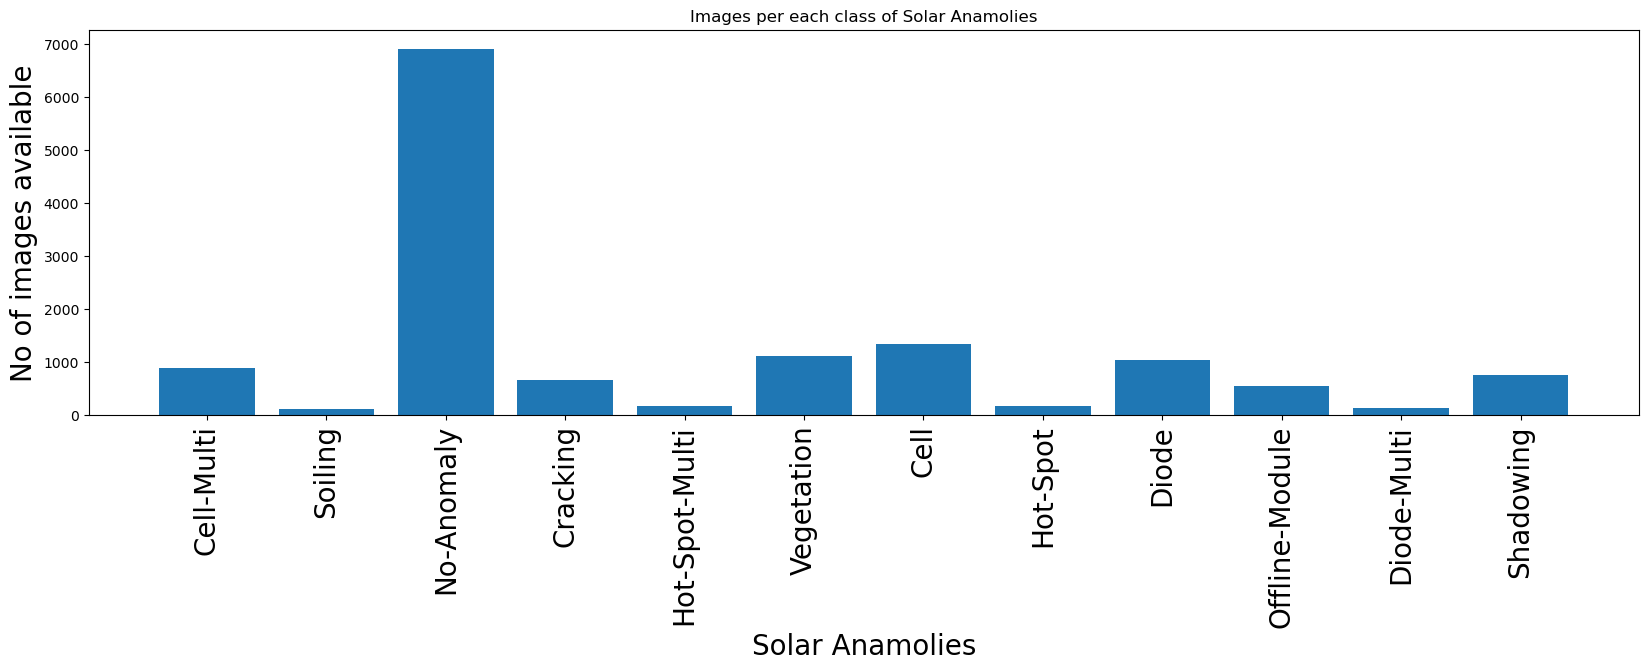

In [82]:
# plotting number of images available for each disease
index = [n for n in range(12)]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in nums.values()], width=0.8)
plt.xlabel('Solar Anamolies', fontsize=20)
plt.ylabel('No of images available', fontsize=20)
plt.xticks(index, anamolies, fontsize=20, rotation=90)
plt.title('Images per each class of Solar Anamolies')

We can see that the dataset is almost balanced for all classes(except Non-Anomaly Class), so we are good to go forward

In [83]:
n_train = 0
for value in nums.values():
    n_train += value
print(f"There are {n_train} images for training")

There are 13893 images for training


## 🍳 Data Preparation for training 🍳

In [84]:
# datasets for validation and training
train = ImageFolder(train_dir, transform=transforms.ToTensor())
valid = ImageFolder(valid_dir, transform=transforms.ToTensor()) 

torchvision.datasets is a class which helps in loading all common and famous datasets. It also helps in loading custom datasets. I have used subclass torchvision.datasets.ImageFolder which helps in loading the image data when the data is arranged in this way:

root/dog/xxx.png

root/dog/xxy.png

root/dog/xxz.png


root/cat/123.png

root/cat/nsdf3.png

root/cat/asd932_.png

In [85]:
img, label = train[0]
print(img.shape, label)

torch.Size([3, 40, 24]) 0


In [86]:
# total number of classes in train set
len(train.classes)

12

In [87]:
# for checking some images from training dataset
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))

## 🖼️ Some Images from training dataset 🖼️

Label :Cell(0)


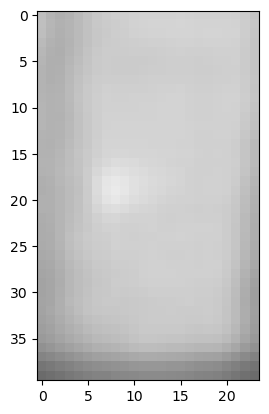

In [88]:
show_image(*train[0])

Label :No-Anomaly(7)


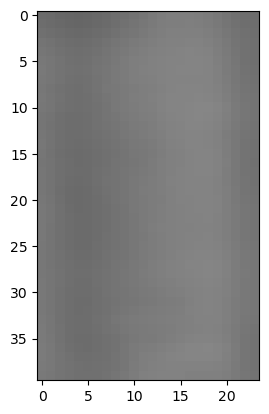

In [89]:
show_image(*train[7000])

Label :Diode(3)


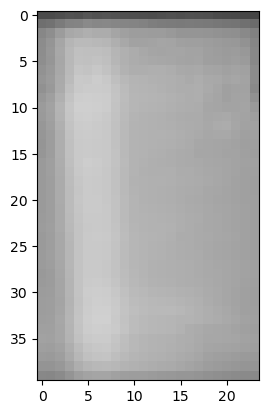

In [90]:
show_image(*train[3000])

In [91]:
# Setting the seed value
random_seed = 7
torch.manual_seed(random_seed)

In [92]:
# setting the batch size
batch_size = 32



batch_size is the total number of images given as input at once in forward propagation of the CNN. Basically, batch size defines the number of samples that will be propagated through the network.

For instance, let's say you have 1050 training samples and you want to set up a batch_size equal to 100. The algorithm takes the first 100 samples (from 1st to 100th) from the training dataset and trains the network. Next, it takes the second 100 samples (from 101st to 200th) and trains the network again. We can keep doing this procedure until we have propagated all samples through of the network.


In [93]:
# DataLoaders for training and validation
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid, batch_size, num_workers=2, pin_memory=True)

- DataLoader is a subclass which comes from torch.utils.data. It helps in loading large and memory consuming datasets. It takes in batch_size which denotes the number of samples contained in each generated batch.

- Setting shuffle=True shuffles the dataset. It is heplful so that batches between epochs do not look alike. Doing so will eventually make our model more robust.

- num_workers, denotes the number of processes that generate batches in parallel. If you have more cores in your CPU, you can set it to number of cores in your CPU. Since, Kaggle provides a 2 core CPU, I have set it to 2

In [94]:
# helper function to show a batch of training instances
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

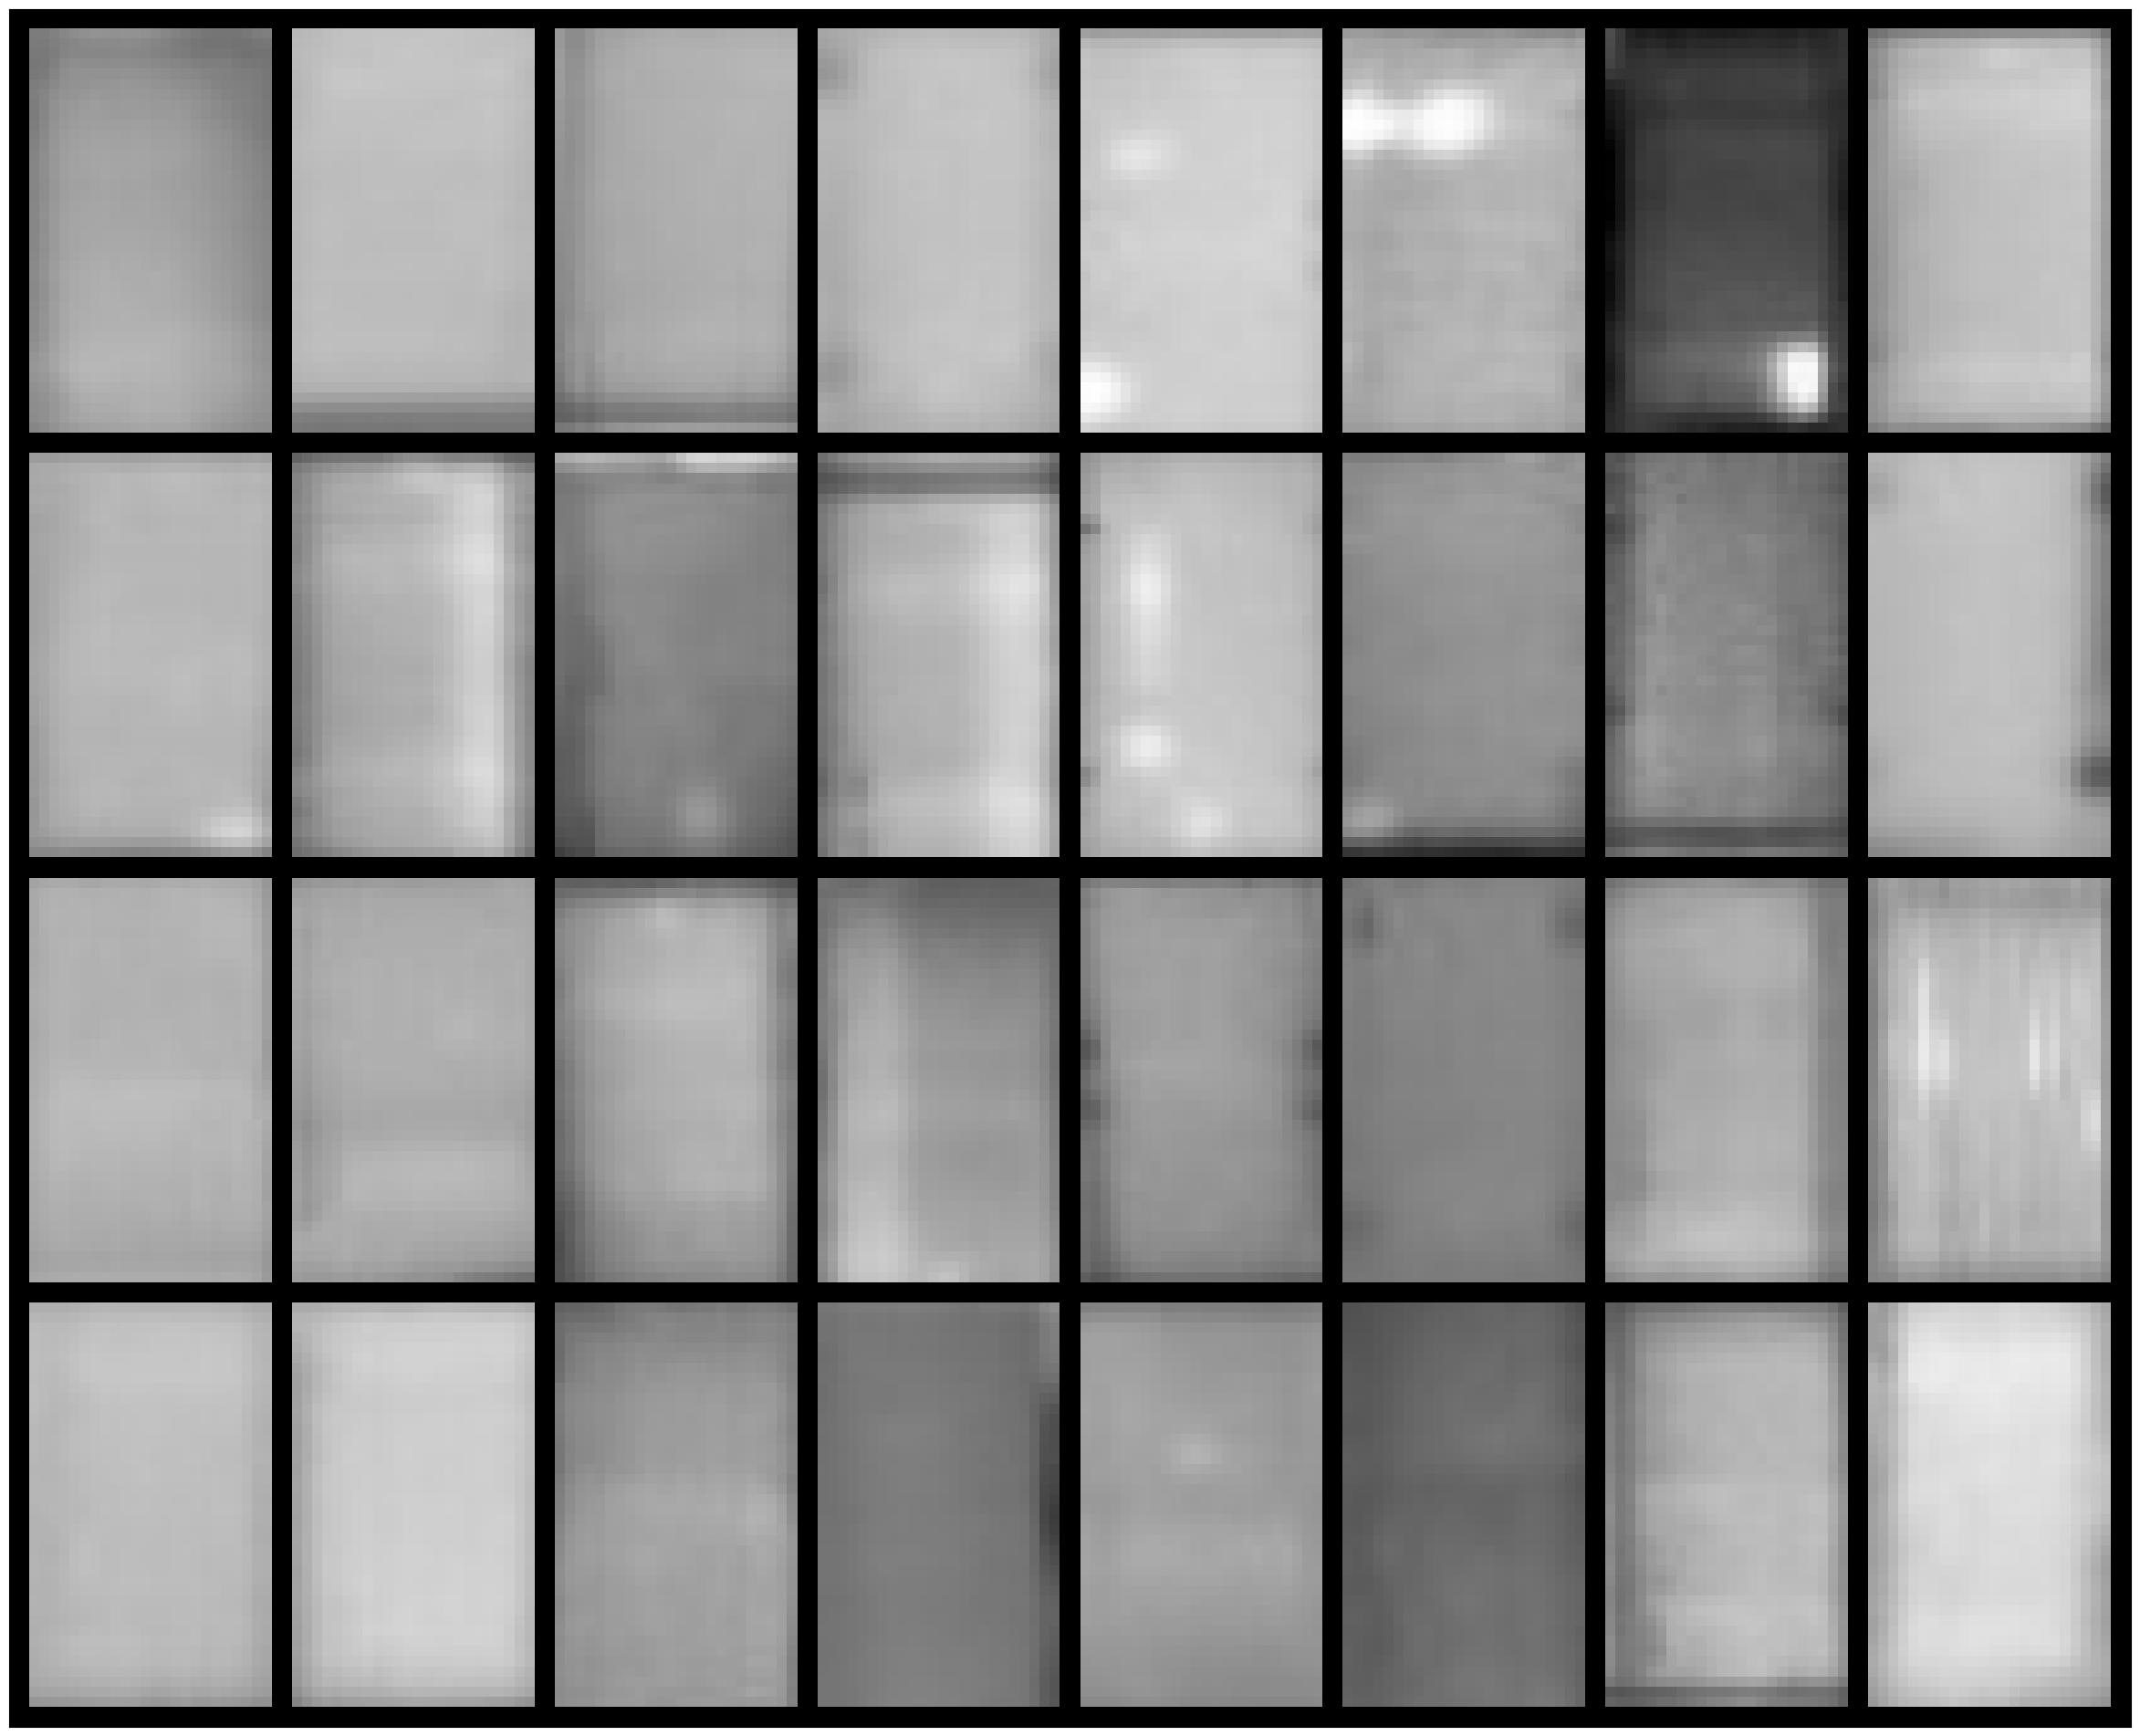

In [95]:
show_batch(train_dl)

## 🏗️ Modelling 🏗️

In [96]:
# for moving data into GPU (if available)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)




Checking the device we are working with


In [97]:
device = get_default_device()
device

device(type='cuda')



Wrap up our training and validation data loaders using DeviceDataLoader for automatically transferring batches of data to the GPU (if available)


In [98]:
# Moving data into GPU
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## 👷 Building the model architecture 👷

We are going to use ResNet, which have been one of the major breakthrough in computer vision since they were introduced in 2015.

In ResNets, unlike in traditional neural networks, each layer feeds into the next layer, we use a network with residual blocks, each layer feeds into the next layer and directly into the layers about 2–3 hops away, to avoid over-fitting (a situation when validation loss stop decreasing at a point and then keeps increasing while training loss still decreases). This also helps in preventing vanishing gradient problem and allow us to train deep neural networks. Here is a simple residual block:

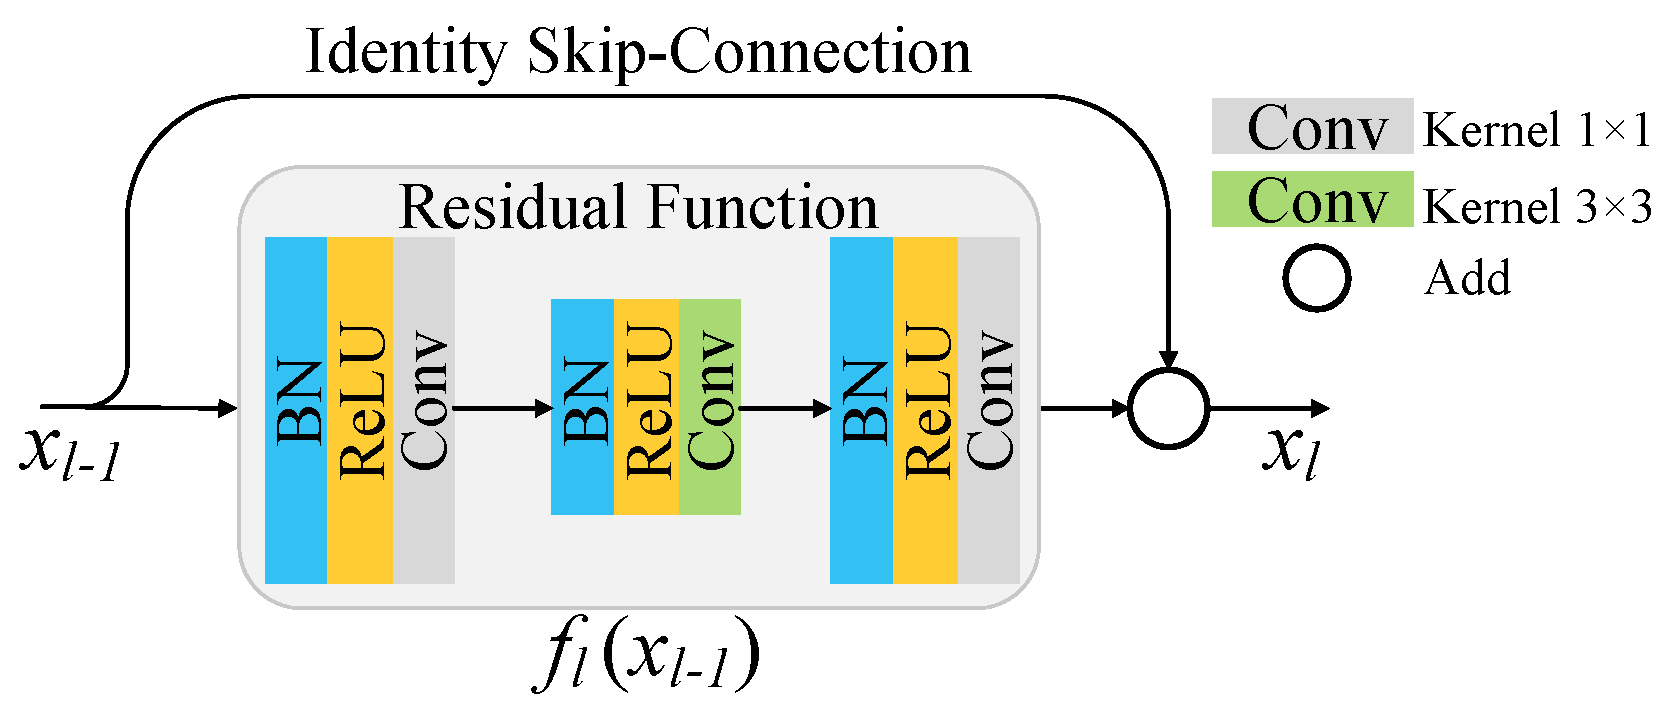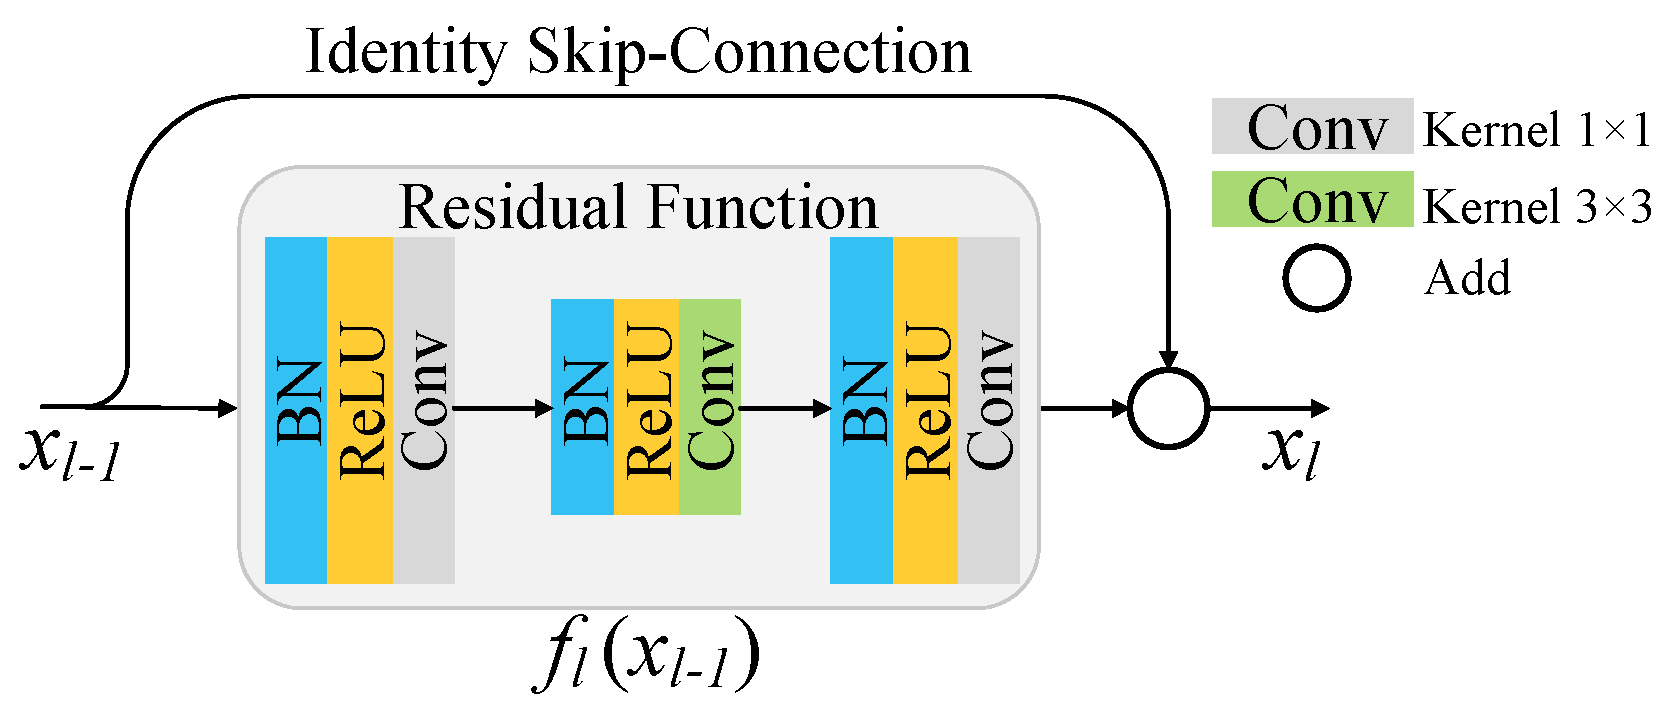

Residual Block code implementation

In [99]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input



Then we define our ImageClassificationBase class whose functions are:

*     training_step - To figure out how “wrong” the model is going after training or validation step.We are using this function other than just an accuracy metric that is likely not going to be differentiable (this would mean that the gradient can’t be determined, which is necessary for the model to improve during training)

A quick look at the PyTorch docs that yields the cost function: cross_entropy.

*     validation_step - Because an accuracy metric can’t be used while training the model, doesn’t mean it shouldn’t be implemented! Accuracy in this case would be measured by a threshold, and counted if the difference between the model’s prediction and the actual label is lower than that threshold.
*     validation_epoch_end - We want to track the validation losses/accuracies and train losses after each epoch, and every time we do so we have to make sure the gradient is not being tracked.
*     epoch_end - We also want to print validation losses/accuracies, train losses and learning rate too because we are using learning rate scheduler (which will change the learning rate after every batch of training) after each epoch.

We also define an accuracy function which calculates the overall accuracy of the model on an entire batch of outputs, so that we can use it as a metric in fit_one_cycle


In [179]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# base class for the model
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss  
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies
    
#     def epoch_end(self, epoch, result):
#         print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
#             epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1].item(), result['train_loss'], result['val_loss'], result['val_accuracy']))
        

## 👷 Defining the final architecture of our model 👷

In [180]:
# Architecture for training

# convolution block with BatchNormalization
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)



class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()

        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True)  # out_dim: 128 x 20 x 12
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))

        self.conv3 = ConvBlock(128, 256, pool=True)  # out_dim: 256 x 10 x 6
        self.conv4 = ConvBlock(256, 512)  # out_dim: 512 x 10 x 6
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))

        self.classifier = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                         nn.Flatten(),
                                         nn.Linear(512, num_diseases))

    def forward(self, xb):  # xb is the loaded batch
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out





Now, we define a model object and transfer it into the device with which we are working..

In [181]:
# defining the model and moving it to the GPU
model = to_device(ResNet9(3, len(train.classes)), device) 
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

Getting a nicely formatted summary of our model (like in Keras). Pytorch doesn't support it natively. So, we need to install the torchsummary library (discussed earlier)

In [183]:
# getting summary of the model
INPUT_SHAPE = (3, 256, 256)
print(summary(model.cuda(), (INPUT_SHAPE)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4        [-1, 128, 256, 256]          73,856
       BatchNorm2d-5        [-1, 128, 256, 256]             256
              ReLU-6        [-1, 128, 256, 256]               0
         MaxPool2d-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
           Conv2d-14          [-1, 256,

## 🏋️ Training the model 🏋️



Before we train the model, Let’s define a utility functionan evaluate function, which will perform the validation phase, and a fit_one_cycle function which will perform the entire training process. In fit_one_cycle, we have use some techniques:

*     Learning Rate Scheduling: Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and the one we’ll use is called the “One Cycle Learning Rate Policy”, which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs.

*     Weight Decay: We also use weight decay, which is a regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.

*     Gradient Clipping: Apart from the layer weights and outputs, it also helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values. This simple yet effective technique is called gradient clipping.

We'll also record the learning rate used for each batch.


In [188]:
# for training
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []
        
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            sched.step()
        
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = torch.tensor(lrs)  # Convert lrs list to a tensor
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history




Let's check our validation loss and accuracy


In [185]:
%%time
history = [evaluate(model, valid_dl)]
history

CPU times: user 497 ms, sys: 134 ms, total: 631 ms
Wall time: 2.09 s


[{'val_loss': tensor(2.4884, device='cuda:0'), 'val_accuracy': tensor(0.0396)}]

Since there are randomly initialized weights, that is why accuracy come to near 0.039 (that is 3.9% chance of getting the right answer or you can say model randomly chooses a class). Now, declare some hyper parameters for the training of the model. We can change it if result is not satisfactory.

In [193]:
epochs = 15
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

Let's start training our model ....

Note: The following cell may take 5 mins to 20 mins to run depending on your GPU. In kaggle (P100 GPU) it took around 3 mins of Wall Time

In [194]:
%%time
history += fit_OneCycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=1e-4, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00152, train_loss: 0.4547, val_loss: 0.6849, val_acc: 0.7858
Epoch [1], last_lr: 0.00436, train_loss: 0.5167, val_loss: 1.1666, val_acc: 0.5854
Epoch [2], last_lr: 0.00760, train_loss: 0.6253, val_loss: 0.7545, val_acc: 0.7523
Epoch [3], last_lr: 0.00971, train_loss: 0.6819, val_loss: 1.6163, val_acc: 0.5675
Epoch [4], last_lr: 0.00994, train_loss: 0.6861, val_loss: 1.2380, val_acc: 0.6394
Epoch [5], last_lr: 0.00950, train_loss: 0.6781, val_loss: 0.8427, val_acc: 0.7412
Epoch [6], last_lr: 0.00867, train_loss: 0.6569, val_loss: 2.3773, val_acc: 0.5420
Epoch [7], last_lr: 0.00750, train_loss: 0.6267, val_loss: 0.9518, val_acc: 0.6900
Epoch [8], last_lr: 0.00611, train_loss: 0.5811, val_loss: 0.9120, val_acc: 0.7062
Epoch [9], last_lr: 0.00463, train_loss: 0.5390, val_loss: 0.7357, val_acc: 0.7619
Epoch [10], last_lr: 0.00317, train_loss: 0.4725, val_loss: 0.6749, val_acc: 0.7830
Epoch [11], last_lr: 0.00188, train_loss: 0.3944, val_loss: 0.6713, val_acc: 0.7909
Ep

We got an accuracy of 80.2 % 🙌🙌

## 📈 Plotting 📈


Helper functions for plotting

In [207]:
def plot_accuracies(history):
    accuracies = [x['val_accuracy'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')

### Validation Accuracy

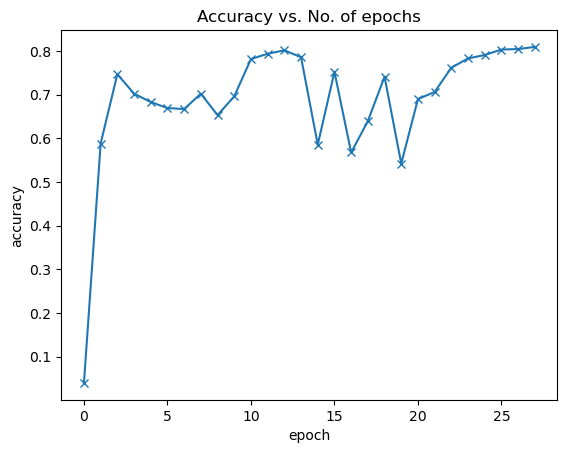

In [208]:
plot_accuracies(history)

### Learning Rate overtime

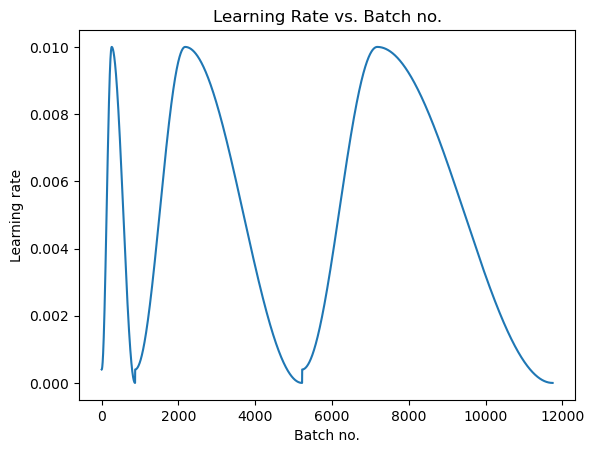

In [209]:
plot_lrs(history)

## 🧪 Testing model on test data 🧪

In [210]:
test_dir = "/kaggle/input/datasetfiles/data/test"
test = ImageFolder(test_dir, transform=transforms.ToTensor())

In [214]:
test_images = sorted(os.listdir(test_dir+'/Cell')) # since images in test folder are in alphabetical order
test_images[:10]

['4849.jpg',
 '4860.jpg',
 '4862.jpg',
 '4873.jpg',
 '4874.jpg',
 '4876.jpg',
 '4879.jpg',
 '4892.jpg',
 '4903.jpg',
 '4910.jpg']

In [215]:
def predict_image(img, model):
    """Converts image to array and return the predicted class
        with highest probability"""
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label

    return train.classes[preds[0].item()]

Label: 4849.jpg , Predicted: Cell


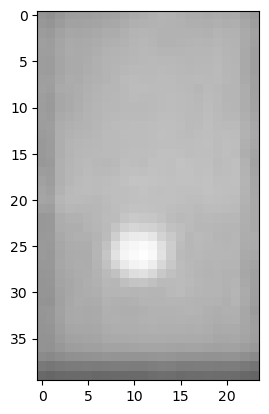

In [216]:
# predicting first image
img, label = test[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_images[0], ', Predicted:', predict_image(img, model))

Label: 4849.jpg , Predicted: Cell


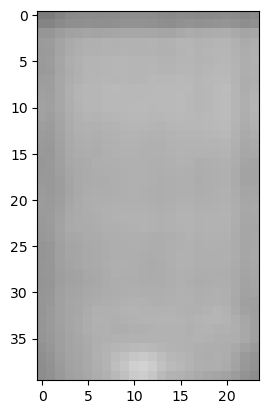

In [223]:
# predicting first image
img, label = test[2]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_images[0], ', Predicted:', predict_image(img, model))

Predicted Results seems good

## Saving the model

In [225]:
# saving to the kaggle working directory
PATH = './solar-Anomaly-model.pth'  
torch.save(model.state_dict(), PATH)

## Conclusion

Thanks for Reading this Notebook Till Now, Please Upvote This NoteBook 🚀